## **서울시 따릉이 대여량 예측 경진대회**

### **서울시 마포구의 날짜별, 시간별 기상상황과 따릉이 대여 수 데이터**

* id 고유 id
* hour 시간
* temperature 기온
* precipitation 비가 오지 않았으면 0, 비가 오면 1
* windspeed 풍속(평균)
* humidity 습도
* visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* ozone 오존
* pm10 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* pm2.5 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count 시간에 따른 따릉이 대여 수

### **라이브러리 로딩**

In [46]:
# 필요한 라이브러리 import하기
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import missingno as msno

### **데이터 살펴보기**

In [47]:
# 데이터 불러오기
train = pd.read_csv('bike_data/train.csv') 
test = pd.read_csv('bike_data/test.csv')

In [48]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [49]:
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [50]:
print(train.shape)
print(test.shape)

(1459, 11)
(715, 10)


train 데이터가 열의 개수가 하나 더 많은 것을 확인할 수 있다. (타겟인 count 포함)

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


모두 실수 또는 정수 자료형으로, 문제 없이 모델 학습에 활용할 수 있을 것 같다.

### **데이터 전처리**

#### **결측치 확인**

<Axes: >

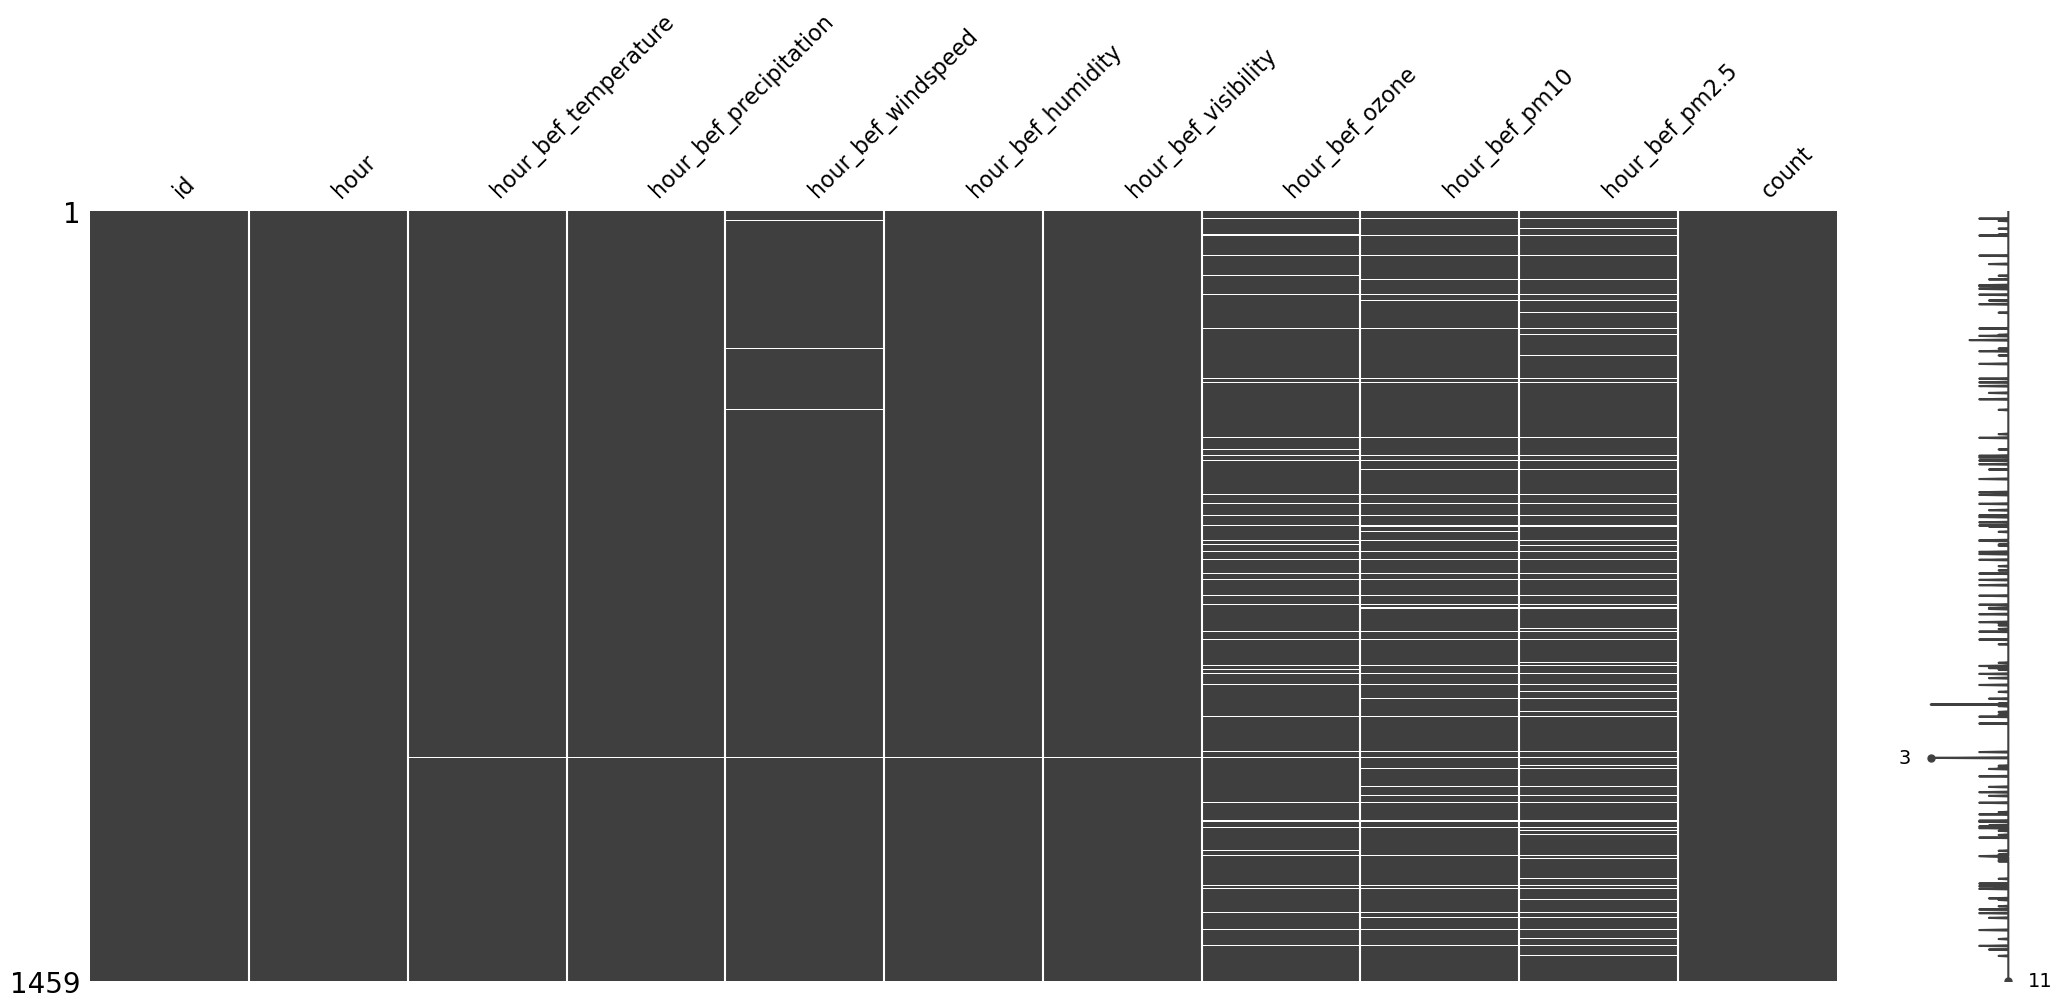

In [52]:
msno.matrix(train)

여러 변수에 결측치가 있는 것으로 보여 확실하게 살펴보도록 하자.

In [53]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))
    # id 컬럼이 결측치인지 확인하고, 결측치인 데이터만 뽑아내고, 결측치인 데이터의 개수를 센다.

id : 0
hour : 0
hour_bef_temperature : 2
hour_bef_precipitation : 2
hour_bef_windspeed : 9
hour_bef_humidity : 2
hour_bef_visibility : 2
hour_bef_ozone : 76
hour_bef_pm10 : 90
hour_bef_pm2.5 : 117
count : 0


test 데이터도 확인해보자.

<Axes: >

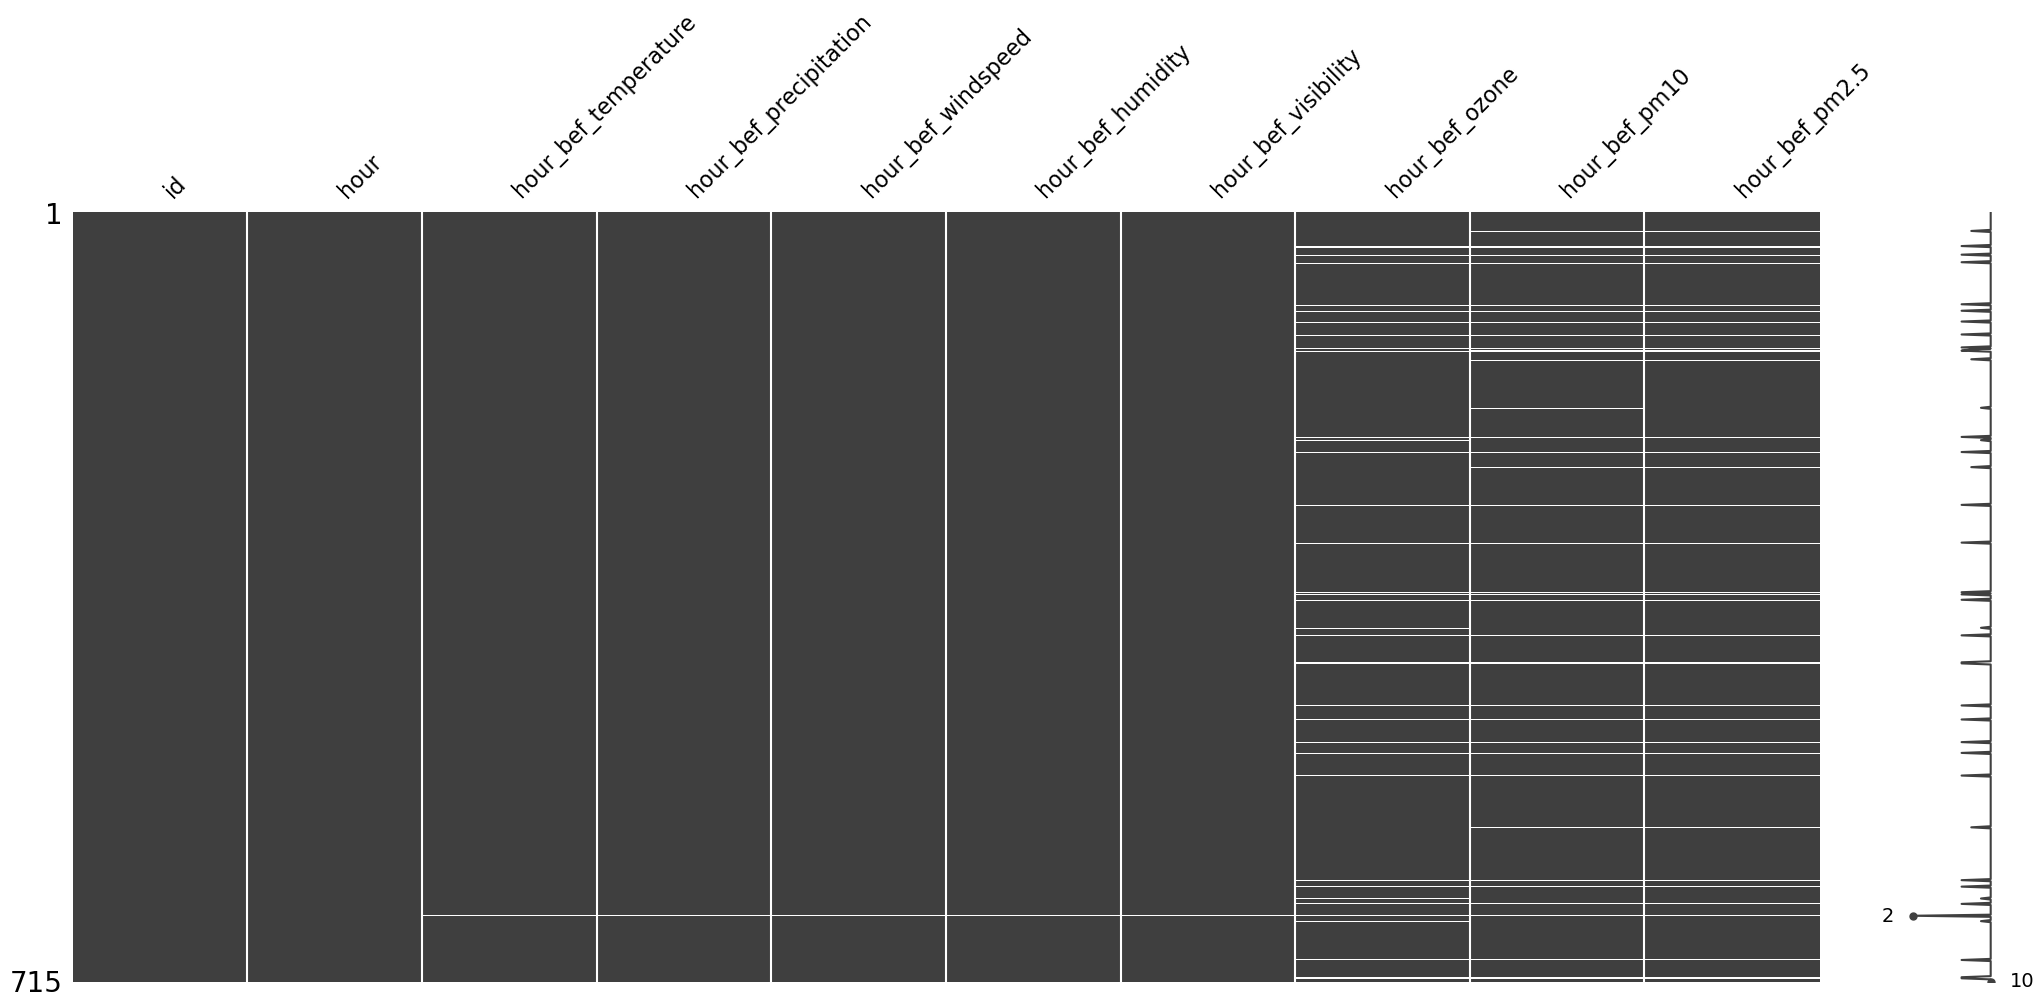

In [54]:
msno.matrix(test)

In [55]:
for c in test.columns:
    print('{} : {}'.format(c, len(test.loc[pd.isnull(test[c]), c].values)))

id : 0
hour : 0
hour_bef_temperature : 1
hour_bef_precipitation : 1
hour_bef_windspeed : 1
hour_bef_humidity : 1
hour_bef_visibility : 1
hour_bef_ozone : 35
hour_bef_pm10 : 37
hour_bef_pm2.5 : 36


train과 test 데이터의 동일한 변수에 같은 양의 결측치가 발견되었다.
<br>결측치를 좀 더 자세히 확인해보자.

In [56]:
# hour_bef_temperature 결측치 확인
train[train['hour_bef_temperature'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


결측치가 모든 변수에 대해 동시에 발생하는 것을 확인할 수 있다.
<br>무의미한 데이터일 가능성이 높다고 판단하여 위의 두 행은 삭제하기로 결정했다.

In [57]:
train = train.drop([934, 1035], axis = 0)

In [58]:
train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          7
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             74
hour_bef_pm10              88
hour_bef_pm2.5            115
count                       0
dtype: int64

나머지 결측치는 평균값으로 대체하도록 하자.

In [59]:
# hour_bef_windspeed 결측치 확인
train[train['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
18,33,13,22.6,0.0,NaN,41.0,987.0,0.046,64.0,39.0,208.0
244,381,1,14.1,0.0,NaN,55.0,1992.0,NaN,NaN,NaN,38.0
260,404,3,14.0,0.0,NaN,50.0,2000.0,0.049,35.0,22.0,17.0
376,570,0,14.3,0.0,NaN,49.0,2000.0,0.044,37.0,20.0,58.0
780,1196,20,16.5,0.0,NaN,31.0,2000.0,0.058,39.0,18.0,181.0
1138,1717,12,21.4,0.0,NaN,44.0,1375.0,0.044,61.0,37.0,116.0
1229,1855,2,14.0,0.0,NaN,52.0,2000.0,0.044,37.0,20.0,20.0


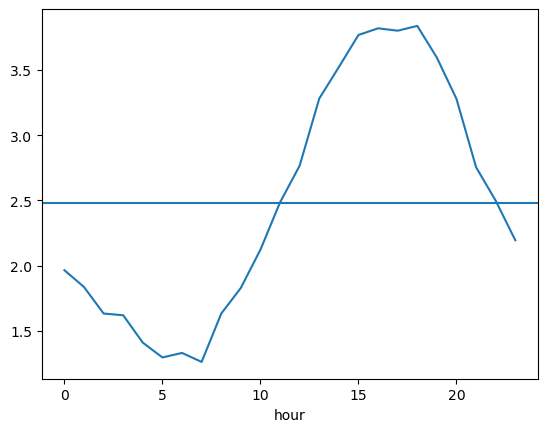

In [60]:
# 시간별 평균 풍속 시각화
train.groupby('hour').mean()['hour_bef_windspeed'].plot()
plt.axhline(train.groupby('hour').mean()['hour_bef_windspeed'].mean())

In [61]:
train.groupby('hour').mean()['hour_bef_windspeed'].round(1)

hour
0     2.0
1     1.8
2     1.6
3     1.6
4     1.4
5     1.3
6     1.3
7     1.3
8     1.6
9     1.8
10    2.1
11    2.5
12    2.8
13    3.3
14    3.5
15    3.8
16    3.8
17    3.8
18    3.8
19    3.6
20    3.3
21    2.8
22    2.5
23    2.2
Name: hour_bef_windspeed, dtype: float64

In [62]:
# 결측치 채우기
train['hour_bef_windspeed'].fillna(train.groupby('hour')['hour_bef_windspeed'].transform('mean').round(1), inplace=True)

In [63]:
# hour_bef_ozone 결측치 확인
train[train['hour_bef_ozone'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
14,28,1,20.0,0.0,1.8,58.0,2000.0,NaN,NaN,NaN,74.0
44,76,17,21.7,0.0,3.0,35.0,2000.0,NaN,32.0,19.0,213.0
46,78,1,12.2,0.0,3.0,49.0,1071.0,NaN,NaN,NaN,36.0
84,130,1,9.4,0.0,2.5,65.0,1907.0,NaN,NaN,NaN,39.0
122,181,16,26.2,0.0,4.3,31.0,1718.0,NaN,47.0,23.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...
1283,1941,1,16.6,0.0,2.1,35.0,2000.0,NaN,NaN,NaN,62.0
1322,1994,1,15.1,0.0,1.3,35.0,2000.0,NaN,NaN,NaN,40.0
1329,2005,1,17.7,0.0,1.0,43.0,1338.0,NaN,NaN,NaN,69.0
1361,2047,1,12.6,0.0,2.4,48.0,1805.0,NaN,NaN,NaN,43.0


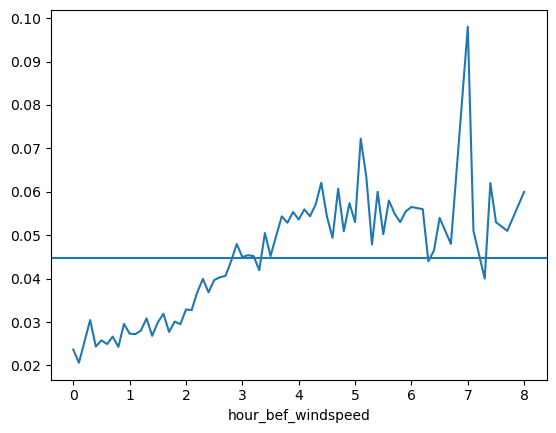

In [64]:
# 풍속에 따른 오존 평균 시각화
train.groupby('hour_bef_windspeed').mean()['hour_bef_ozone'].plot()
plt.axhline(train.groupby('hour_bef_windspeed').mean()['hour_bef_ozone'].mean())

In [65]:
train.groupby('hour_bef_windspeed').mean()['hour_bef_ozone'].round(3)

hour_bef_windspeed
0.0    0.024
0.1    0.021
0.2    0.026
0.3    0.030
0.4    0.024
       ...  
7.3    0.040
7.4    0.062
7.5    0.053
7.7    0.051
8.0    0.060
Name: hour_bef_ozone, Length: 73, dtype: float64

In [66]:
# 결측치 채우기
train['hour_bef_ozone'].fillna(train.groupby('hour_bef_windspeed')['hour_bef_ozone'].transform('mean').round(3), inplace=True)

In [67]:
# hour_bef_pm10 결측치 확인
train[train['hour_bef_pm10'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
14,28,1,20.0,0.0,1.8,58.0,2000.0,0.030,NaN,NaN,74.0
46,78,1,12.2,0.0,3.0,49.0,1071.0,0.045,NaN,NaN,36.0
84,130,1,9.4,0.0,2.5,65.0,1907.0,0.040,NaN,NaN,39.0
100,149,16,15.8,0.0,5.3,17.0,1923.0,0.047,NaN,NaN,102.0
129,193,19,27.0,0.0,3.6,39.0,2000.0,0.047,NaN,NaN,319.0
...,...,...,...,...,...,...,...,...,...,...,...
1329,2005,1,17.7,0.0,1.0,43.0,1338.0,0.027,NaN,NaN,69.0
1338,2016,19,16.2,0.0,3.5,31.0,950.0,0.060,NaN,NaN,167.0
1361,2047,1,12.6,0.0,2.4,48.0,1805.0,0.037,NaN,NaN,43.0
1391,2086,1,11.5,0.0,3.2,23.0,2000.0,0.045,NaN,NaN,42.0


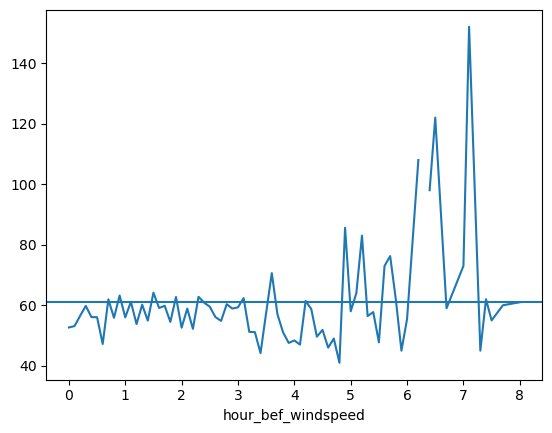

In [68]:
# 풍속에 따른 pm10 미세먼지 평균 시각화
train.groupby('hour_bef_windspeed').mean()['hour_bef_pm10'].plot()
plt.axhline(train.groupby('hour_bef_windspeed').mean()['hour_bef_pm10'].mean())

In [69]:
train.groupby('hour_bef_windspeed').mean()['hour_bef_pm10'].round(1)

hour_bef_windspeed
0.0    52.7
0.1    53.1
0.2    56.5
0.3    59.8
0.4    56.1
       ... 
7.3    45.0
7.4    62.0
7.5    55.0
7.7    60.0
8.0    61.0
Name: hour_bef_pm10, Length: 73, dtype: float64

In [70]:
# 결측치 채우기
train['hour_bef_pm10'].fillna(train.groupby('hour_bef_windspeed')['hour_bef_pm10'].transform('mean').round(1), inplace=True)

In [71]:
# hour_bef_pm2.5 결측치 확인
train[train['hour_bef_pm2.5'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
14,28,1,20.0,0.0,1.8,58.0,2000.0,0.030,54.5,NaN,74.0
33,56,21,10.2,0.0,0.5,84.0,1668.0,0.021,24.0,NaN,127.0
46,78,1,12.2,0.0,3.0,49.0,1071.0,0.045,59.3,NaN,36.0
84,130,1,9.4,0.0,2.5,65.0,1907.0,0.040,59.5,NaN,39.0
100,149,16,15.8,0.0,5.3,17.0,1923.0,0.047,56.4,NaN,102.0
...,...,...,...,...,...,...,...,...,...,...,...
1361,2047,1,12.6,0.0,2.4,48.0,1805.0,0.037,60.9,NaN,43.0
1378,2066,11,10.1,0.0,1.5,59.0,990.0,0.015,39.0,NaN,78.0
1391,2086,1,11.5,0.0,3.2,23.0,2000.0,0.045,51.2,NaN,42.0
1398,2096,20,14.0,0.0,2.9,35.0,910.0,0.061,58.9,NaN,117.0


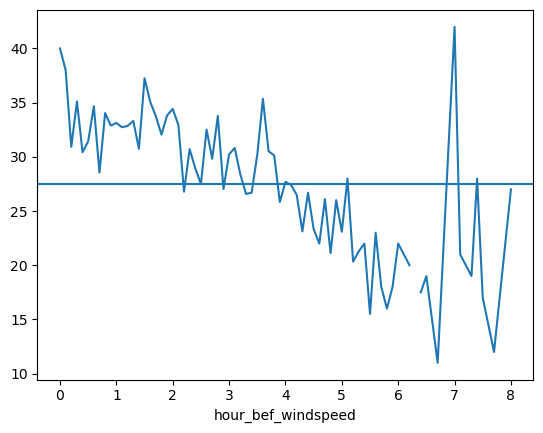

In [72]:
# 풍속에 따른 pm2.5 미세먼지 평균 시각화
train.groupby('hour_bef_windspeed').mean()['hour_bef_pm2.5'].plot()
plt.axhline(train.groupby('hour_bef_windspeed').mean()['hour_bef_pm2.5'].mean())

In [73]:
train.groupby('hour_bef_windspeed').mean()['hour_bef_pm2.5'].round(1)

hour_bef_windspeed
0.0    40.0
0.1    38.0
0.2    30.9
0.3    35.1
0.4    30.4
       ... 
7.3    19.0
7.4    28.0
7.5    17.0
7.7    12.0
8.0    27.0
Name: hour_bef_pm2.5, Length: 73, dtype: float64

In [74]:
# 결측치 채우기
train['hour_bef_pm2.5'].fillna(train.groupby('hour_bef_windspeed')['hour_bef_pm2.5'].transform('mean').round(1), inplace=True)

In [75]:
train.isna().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             1
hour_bef_pm2.5            1
count                     0
dtype: int64

In [76]:
# hour_bef_temperature 결측치 확인
test[test['hour_bef_temperature'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
653,1943,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
test = test.drop([653], axis = 0)

In [78]:
test.isna().sum()

id                         0
hour                       0
hour_bef_temperature       0
hour_bef_precipitation     0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_visibility        0
hour_bef_ozone            34
hour_bef_pm10             36
hour_bef_pm2.5            35
dtype: int64

In [79]:
# hour_bef_ozone 결측치 확인
test[test['hour_bef_ozone'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
32,82,1,22.8,0.0,2.4,52.0,2000.0,NaN,NaN,NaN
40,115,1,21.5,1.0,0.5,90.0,347.0,NaN,NaN,NaN
47,147,1,22.8,0.0,1.2,57.0,1190.0,NaN,NaN,NaN
86,260,1,20.0,0.0,2.0,65.0,1662.0,NaN,NaN,NaN
92,270,1,20.0,0.0,1.7,31.0,2000.0,NaN,NaN,NaN
102,297,1,15.1,1.0,2.2,98.0,224.0,NaN,NaN,NaN
114,323,1,18.7,0.0,1.4,41.0,2000.0,NaN,NaN,NaN
126,352,1,19.2,0.0,1.4,80.0,1085.0,NaN,NaN,NaN
129,358,1,23.6,0.0,0.9,83.0,466.0,NaN,NaN,NaN
209,609,1,18.6,0.0,2.4,37.0,2000.0,NaN,NaN,NaN


In [80]:
test.groupby('hour_bef_windspeed').mean()['hour_bef_ozone'].round(3)

hour_bef_windspeed
0.0    0.014
0.1    0.019
0.2    0.025
0.3    0.018
0.4    0.015
0.5    0.019
0.6    0.027
0.7    0.017
0.8    0.019
0.9    0.027
1.0    0.024
1.1    0.022
1.2    0.031
1.3    0.032
1.4    0.033
1.5    0.034
1.6    0.035
1.7    0.039
1.8    0.039
1.9    0.038
2.0    0.041
2.1    0.039
2.2    0.043
2.3    0.036
2.4    0.041
2.5    0.043
2.6    0.043
2.7    0.044
2.8    0.048
2.9    0.044
3.0    0.050
3.1    0.064
3.2    0.048
3.3    0.049
3.4    0.052
3.5    0.054
3.6    0.057
3.7    0.048
3.8    0.052
3.9    0.056
4.0    0.054
4.1    0.059
4.2    0.058
4.3    0.048
4.4    0.065
4.5    0.063
4.6    0.064
4.7    0.058
4.8    0.056
4.9    0.073
5.0    0.041
5.1    0.038
5.2    0.062
5.3    0.044
5.4    0.062
5.7    0.049
5.9    0.046
Name: hour_bef_ozone, dtype: float64

In [81]:
# 결측치 채우기
test['hour_bef_ozone'].fillna(test.groupby('hour_bef_windspeed')['hour_bef_ozone'].transform('mean').round(3), inplace=True)

In [82]:
# hour_bef_pm10 결측치 확인
test[test['hour_bef_pm10'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
18,42,18,29.4,0.0,3.3,43.0,1685.0,0.055,NaN,NaN
32,82,1,22.8,0.0,2.4,52.0,2000.0,0.041,NaN,NaN
40,115,1,21.5,1.0,0.5,90.0,347.0,0.019,NaN,NaN
47,147,1,22.8,0.0,1.2,57.0,1190.0,0.031,NaN,NaN
86,260,1,20.0,0.0,2.0,65.0,1662.0,0.041,NaN,NaN
92,270,1,20.0,0.0,1.7,31.0,2000.0,0.039,NaN,NaN
102,297,1,15.1,1.0,2.2,98.0,224.0,0.043,NaN,NaN
114,323,1,18.7,0.0,1.4,41.0,2000.0,0.033,NaN,NaN
126,352,1,19.2,0.0,1.4,80.0,1085.0,0.033,NaN,NaN
128,356,15,25.5,0.0,3.6,40.0,1404.0,0.077,NaN,NaN


In [83]:
test.groupby('hour_bef_windspeed').mean()['hour_bef_pm10'].round(1)

hour_bef_windspeed
0.0    37.0
0.1    43.0
0.2    46.0
0.3    36.0
0.4    31.7
0.5    31.2
0.6    28.2
0.7    37.8
0.8    38.6
0.9    32.3
1.0    33.2
1.1    37.2
1.2    35.6
1.3    35.0
1.4    39.3
1.5    36.9
1.6    29.2
1.7    35.0
1.8    35.5
1.9    41.3
2.0    37.5
2.1    33.4
2.2    35.7
2.3    35.6
2.4    33.4
2.5    34.9
2.6    40.3
2.7    38.4
2.8    35.2
2.9    36.7
3.0    41.8
3.1    41.6
3.2    34.6
3.3    42.1
3.4    37.2
3.5    39.2
3.6    44.1
3.7    37.3
3.8    38.1
3.9    42.9
4.0    46.5
4.1    35.8
4.2    36.9
4.3    36.4
4.4    40.3
4.5    33.3
4.6    41.0
4.7    44.0
4.8    39.3
4.9    53.3
5.0    34.0
5.1    39.5
5.2    35.0
5.3    44.0
5.4    51.0
5.7    34.0
5.9    33.0
Name: hour_bef_pm10, dtype: float64

In [84]:
# 결측치 채우기
test['hour_bef_pm10'].fillna(test.groupby('hour_bef_windspeed')['hour_bef_pm10'].transform('mean').round(1), inplace=True)

In [85]:
# hour_bef_pm2.5 결측치 확인
test[test['hour_bef_pm2.5'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
18,42,18,29.4,0.0,3.3,43.0,1685.0,0.055,42.1,NaN
32,82,1,22.8,0.0,2.4,52.0,2000.0,0.041,33.4,NaN
40,115,1,21.5,1.0,0.5,90.0,347.0,0.019,31.2,NaN
47,147,1,22.8,0.0,1.2,57.0,1190.0,0.031,35.6,NaN
86,260,1,20.0,0.0,2.0,65.0,1662.0,0.041,37.5,NaN
92,270,1,20.0,0.0,1.7,31.0,2000.0,0.039,35.0,NaN
102,297,1,15.1,1.0,2.2,98.0,224.0,0.043,35.7,NaN
114,323,1,18.7,0.0,1.4,41.0,2000.0,0.033,39.3,NaN
126,352,1,19.2,0.0,1.4,80.0,1085.0,0.033,39.3,NaN
128,356,15,25.5,0.0,3.6,40.0,1404.0,0.077,44.1,NaN


In [86]:
test.groupby('hour_bef_windspeed').mean()['hour_bef_pm2.5'].round(1)

hour_bef_windspeed
0.0    27.0
0.1    33.3
0.2    36.0
0.3    25.7
0.4    22.8
0.5    19.6
0.6    19.5
0.7    26.3
0.8    22.9
0.9    23.6
1.0    22.9
1.1    26.4
1.2    24.9
1.3    23.3
1.4    28.6
1.5    25.0
1.6    21.2
1.7    23.9
1.8    26.5
1.9    28.3
2.0    25.1
2.1    22.2
2.2    26.8
2.3    24.3
2.4    24.1
2.5    23.1
2.6    26.7
2.7    27.5
2.8    21.7
2.9    23.9
3.0    27.3
3.1    28.8
3.2    19.8
3.3    30.0
3.4    24.8
3.5    25.8
3.6    28.9
3.7    26.0
3.8    22.7
3.9    29.1
4.0    30.2
4.1    22.8
4.2    21.0
4.3    21.9
4.4    26.0
4.5    21.0
4.6    24.0
4.7    31.0
4.8    25.7
4.9    36.7
5.0    19.5
5.1    27.0
5.2    22.0
5.3    28.7
5.4    31.7
5.7    25.0
5.9    15.0
Name: hour_bef_pm2.5, dtype: float64

In [87]:
# 결측치 채우기
test['hour_bef_pm2.5'].fillna(test.groupby('hour_bef_windspeed')['hour_bef_pm2.5'].transform('mean').round(1), inplace=True)

In [88]:
test.isna().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

<Axes: >

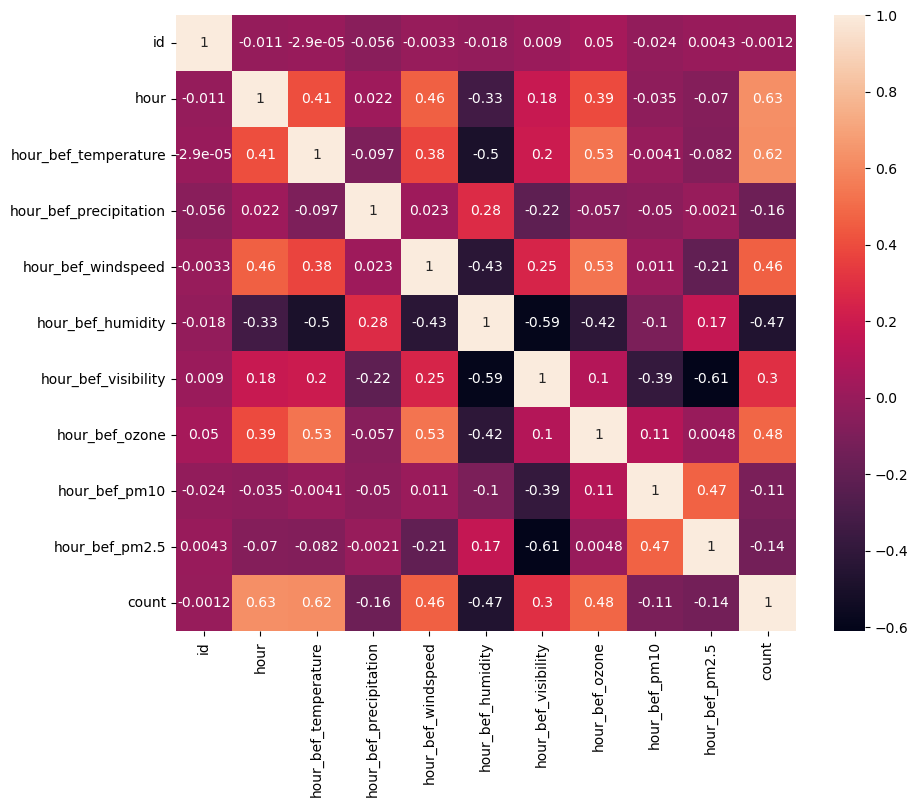

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(),annot=True)

#### **id 변수 정리**

In [204]:
# id 컬럼 삭제
del train['id']

print(train.columns)

Index(['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')


In [205]:
# id 컬럽 삭제
del test['id']

print(test.columns)

Index(['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5'],
      dtype='object')


In [206]:
# 타겟 데이터 확인
y

NameError: name 'y' is not defined

In [ ]:
# 분포 확인
sns.kdeplot(y)
plt.show()

#### **상관관계 확인하기**

In [ ]:
corr = train[['hour', 'hour_bef_temperature', 'hour_bef_precipitation', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count']].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation between variables')
plt.show()

In [ ]:
hourly_rentals = train.groupby('hour').mean()['count']
plt.bar(hourly_rentals.index, hourly_rentals.values)
plt.xlabel('Hour of the day')
plt.ylabel('Average rentals')
plt.title('Hourly average bike rentals')
plt.show()

대여량이 8시, 17시에 갑자기 증가하는 것을 확인할 수 있다.
<br>이를 토대로 출퇴근, 등하교 시간에 대여량이 증가한다고 추측할 수 있을 것 같다.

### **모델 정의 및 학습**

In [ ]:
train_x = train.drop(['count'],axis = 1)
train_y = train['count']

In [ ]:
model=RandomForestRegressor(n_estimators=100)
model.fit(train_x,train_y)

### **학습 된 모델로 예측 데이터 생성**

In [ ]:
pred = model.predict(test)

###  **제출파일 생성**

In [ ]:
submission = pd.read_csv('/content/data/submission.csv')
submission

In [ ]:
submission['count'] = pred

In [ ]:
submission

In [ ]:
submission.to_csv('베이스라인.csv',index = False)